# 学習済みのCNNを使用する

## 特徴抽出

モジュールとして提供されている画像分類モデル
* Xception
* Inception V3
* ResNet50
* VGG16
* VGG19
* MobileNet
### VGG16モデルのたたみ込みベースのインスタンス化


In [1]:
from keras.applications import VGG16
IMAGE_SIZE = 256

conv_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

Using TensorFlow backend.


In [2]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

## データ拡張を行わない高速な特徴抽出
### 学習済みたたみ込みベースを使って特徴量を抽出


In [4]:
import os
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

mini_metadata = pd.read_csv('mini_metadata.csv',index_col=0)
classes = list(mini_metadata["make_model"].value_counts().index)
classes = sorted(classes)
classes_num = len(mini_metadata.groupby("make_model"))

base_dir = 'mini_pictures'

train_dir = os.path.join(base_dir,'train')
valid_dir = os.path.join(base_dir,'valid')
test_dir = os.path.join(base_dir,'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 8, 8, 512)) #このshapeになる理由->block5_pool (MaxPooling2D)   (None, 8, 8, 512)
    labels = np.zeros(shape=(sample_count,classes_num)) #labelsのshapeについて確認
    generator = datagen.flow_from_directory(directory,
                                           target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                           batch_size=batch_size,
                                           class_mode='categorical',
                                           classes=classes)
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i*batch_size:(i+1)*batch_size] = features_batch
        labels[i*batch_size:(i+1)*batch_size] = labels_batch
        i += 1
        if i*batch_size >= sample_count:# ジェネレータはデータを無限ループで生成するため画像を一通り処理したらbreak
            break
    return features,labels
train_cnt = 0
valid_cnt = 0
test_cnt = 0
for _class in classes:
    train_label_dir = os.path.join(train_dir, _class)
    train_cnt += len([f for f in os.listdir(train_label_dir) if os.path.isfile(os.path.join(train_label_dir, f))])
    valid_label_dir = os.path.join(valid_dir, _class)
    valid_cnt += len([f for f in os.listdir(valid_label_dir) if os.path.isfile(os.path.join(valid_label_dir, f))])
    test_label_dir = os.path.join(test_dir, _class)
    test_cnt += len([f for f in os.listdir(test_label_dir) if os.path.isfile(os.path.join(test_label_dir, f))])
print(train_cnt,valid_cnt,test_cnt)

train_features, train_labels = extract_features(train_dir,train_cnt)
valid_features, valid_labels = extract_features(valid_dir,valid_cnt)
test_features, test_labels = extract_features(test_dir,test_cnt)

1912 657 663
Found 1912 images belonging to 20 classes.
Found 657 images belonging to 20 classes.
Found 663 images belonging to 20 classes.


In [6]:
train_features = np.reshape(train_features, (train_cnt, 8 * 8 * 512))
valid_features = np.reshape(valid_features, (valid_cnt, 8 * 8 * 512))
test_features = np.reshape(test_features, (test_cnt, 8 * 8 * 512))

### *このモデルでは入力として画像を受け取ることはできない  
VGG16から抽出した特徴量をもとに分類をするモデルを作成している

In [10]:
from keras import models 
from keras import layers 
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=8*8*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(classes_num, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
             loss='categorical_crossentropy',
             metrics=['acc'])

history = model.fit(train_features, train_labels,
                   epochs=100,
                   batch_size=32,
                   validation_data=(valid_features, valid_labels))

Train on 1912 samples, validate on 657 samples
Epoch 1/100
1912/1912 [==============================] - 25s 13ms/step - loss: 2.9189 - acc: 0.1198 - val_loss: 2.6180 - val_acc: 0.2481
Epoch 2/100
1912/1912 [==============================] - 20s 10ms/step - loss: 2.4977 - acc: 0.2751 - val_loss: 2.3070 - val_acc: 0.3714
Epoch 3/100
1912/1912 [==============================] - 21s 11ms/step - loss: 2.2113 - acc: 0.3808 - val_loss: 2.0552 - val_acc: 0.5129
Epoch 4/100
1912/1912 [==============================] - 27s 14ms/step - loss: 1.9500 - acc: 0.4749 - val_loss: 1.8415 - val_acc: 0.5525
Epoch 5/100
1912/1912 [==============================] - 28s 15ms/step - loss: 1.7557 - acc: 0.5361 - val_loss: 1.6452 - val_acc: 0.6651
Epoch 6/100
1912/1912 [==============================] - 26s 13ms/step - loss: 1.5608 - acc: 0.5994 - val_loss: 1.4757 - val_acc: 0.7291
Epoch 7/100
1912/1912 [==============================] - 26s 14ms/step - loss: 1.4002 - acc: 0.6559 - val_loss: 1.3478 - val_acc: 0

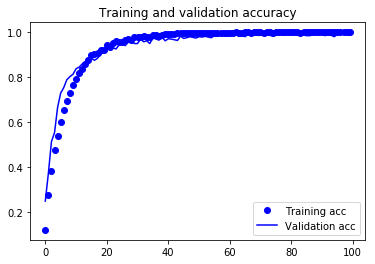

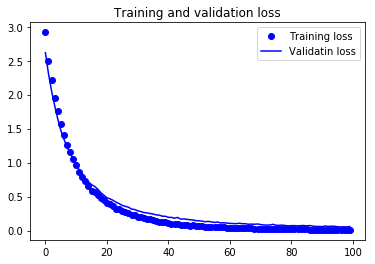

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

#正解率をプロット
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

#損失値をプロット
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validatin loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [12]:
model.save("model/VGG16_model_mini_1.h5")

# 入力を画像で受け取ることができる転移学習モデル

In [13]:
import os
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

mini_metadata = pd.read_csv('mini_metadata.csv',index_col=0)
classes = list(mini_metadata["make_model"].value_counts().index)
classes = sorted(classes)
classes_num = len(mini_metadata.groupby("make_model"))

base_dir = 'mini_pictures'

train_dir = os.path.join(base_dir,'train')
valid_dir = os.path.join(base_dir,'valid')
test_dir = os.path.join(base_dir,'test')


In [16]:
from keras.layers import Dense, GlobalAveragePooling2D,Input
import os.path,sys
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
import keras.callbacks
from keras.applications import VGG16
from keras.optimizers import Adam

N_CATEGORIES  = 20
IMAGE_SIZE = 256
BATCH_SIZE = 16


pictures_files = os.listdir(train_dir)
NUM_TRAINING = 0
NUM_VALIDATION = 0
for i in range(classes_num):
    NUM_TRAINING += len(os.listdir(os.path.join(train_dir, pictures_files[i])))
    NUM_VALIDATION += len(os.listdir(os.path.join(valid_dir, pictures_files[i])))
print(NUM_TRAINING,NUM_VALIDATION)

conv_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = conv_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(N_CATEGORIES, activation='softmax')(x)
model = Model(inputs=conv_base.input, outputs=predictions)

for layer in conv_base.layers:
    layer.trainable = False
model.compile(optimizer=Adam(lr=5e-4), loss='categorical_crossentropy',metrics=['accuracy'])

model.summary()

1912 657
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)  

In [18]:
train_datagen = ImageDataGenerator(
   rescale=1.0 / 255,)

test_datagen = ImageDataGenerator(
   rescale=1.0 / 255,
)

train_generator = train_datagen.flow_from_directory(
   train_dir,
   target_size=(IMAGE_SIZE, IMAGE_SIZE),
   batch_size=BATCH_SIZE,
   class_mode='categorical',
   shuffle=True
)

validation_generator = test_datagen.flow_from_directory(
   valid_dir,
   target_size=(IMAGE_SIZE, IMAGE_SIZE),
   batch_size=BATCH_SIZE,
   class_mode='categorical',
   shuffle=True
)

history = model.fit_generator(train_generator,
   steps_per_epoch=NUM_TRAINING//BATCH_SIZE,
   epochs=100,
   verbose=1,
   validation_data=validation_generator,
   validation_steps=NUM_VALIDATION//BATCH_SIZE,
   )

Found 1912 images belonging to 20 classes.
Found 657 images belonging to 20 classes.
Epoch 1/100
119/119 [==============================] - 1427s 12s/step - loss: 2.0526 - accuracy: 0.4393 - val_loss: 1.9173 - val_accuracy: 0.4726
Epoch 2/100
119/119 [==============================] - 1649s 14s/step - loss: 1.7796 - accuracy: 0.5380 - val_loss: 1.9339 - val_accuracy: 0.5164
Epoch 3/100
119/119 [==============================] - 2251s 19s/step - loss: 1.5546 - accuracy: 0.6118 - val_loss: 1.4713 - val_accuracy: 0.5710
Epoch 4/100
119/119 [==============================] - 2038s 17s/step - loss: 1.3553 - accuracy: 0.6730 - val_loss: 1.5055 - val_accuracy: 0.6100
Epoch 5/100
119/119 [==============================] - 2038s 17s/step - loss: 1.1909 - accuracy: 0.7336 - val_loss: 1.3002 - val_accuracy: 0.6864
Epoch 6/100
119/119 [==============================] - 2036s 17s/step - loss: 1.0568 - accuracy: 0.7695 - val_loss: 1.1517 - val_accuracy: 0.7223
Epoch 7/100
119/119 [==================

In [47]:
model.save('models/VGG16_mini_3.h5')
import codecs, pickle, json
b = {}
for k,v in history.history.items():
    b.update({k: [float(v_) for v_ in v]})

with open('histories/history_VGG16_mini_3.json', 'w') as f:
    json.dump(b, f)
f = open('histories/history_VGG16_mini_3.json', 'r')
history = json.load(f)
f.close()

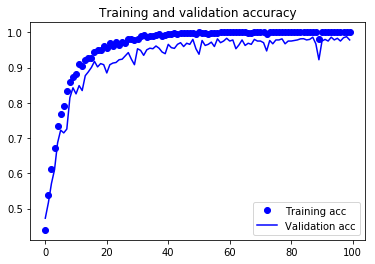

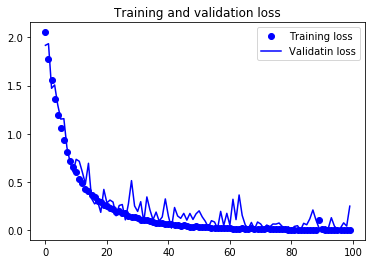

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

epochs = range(len(acc))

#正解率をプロット
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

#損失値をプロット
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validatin loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()